# Introduction to Python and Jupyter Notebooks

Welcome to this tutorial on using Python and machine learning to classify the MNIST handwritten digit dataset. In this notebook, we'll cover the basics of Python programming and the Jupyter Notebook environment, as well as how to install packages and import libraries.

## What is Python?
Python is a high-level, general-purpose programming language that is widely used for a variety of applications, including web development, data analysis, machine learning, and scientific computing. Python is known for its simplicity, readability, and ease of use, making it a great language for beginners to learn.

## What is a Jupyter Notebook?
A Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, visualizations, and narrative text. Jupyter Notebooks are often used for data exploration, analysis, and presentation. They provide an interactive coding environment where you can write, execute, and document your code all in one place.

## Installing Packages
In Python, you can extend the functionality of the language by installing packages, which are collections of modules, functions, and data that provide specific capabilities. You can install packages using a package manager like `pip`, the Python Package Installer.

For example, to install the `numpy` package, which provides support for large, multi-dimensional arrays and matrices, you would run the following command in your terminal or command prompt:

```
pip install numpy
```




In [2]:
! pip install -q torch torchvision scikit-learn matplotlib seaborn seaborn_image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.9 MB/s eta 0:00:00


In [3]:
# Create output folder
import pathlib
pathlib.Path("mnist_pytorch_output").mkdir(parents=True, exist_ok=True)


## Importing Libraries
In addition to installing packages, you can also import Python libraries directly into your Jupyter Notebook. Libraries are collections of pre-written code that provide specific functionality, such as data manipulation, visualization, or machine learning.

For example, to use the `pandas` library for data manipulation, you would write:

```python
import pandas as pd
```

This allows you to use the `pd` prefix to access the functions and features of the `pandas` library.

In the next code block, we import the libraries that we will be needing in
this notebook.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

This import block above sets up the core PyTorch libraries and utilities we'll need to build and train a neural network model to classify handwritten digits from the MNIST dataset.

Let's walk through the packages and what the code above is doing.

```python
import torch
import torch.nn as nn
import torch.optim as optim
```

These lines import the core [PyTorch] library, which is a popular open-source machine learning framework. `torch` provides the fundamental data structures, mathematical operations, and hardware acceleration needed for building and training neural networks.

[PyTorch]: https://pytorch.org/

`torch.nn` contains the building blocks for creating neural network layers and models.
`torch.optim` provides optimization algorithms, like gradient descent, that are used to train neural networks.

```python
from torchvision import datasets, transforms
```

`torchvision` is a [PyTorch] library that provides pre-built datasets and data transformation functions. Here, we're specifically importing the `datasets` and `transforms` modules.

`datasets` contains commonly used machine learning datasets, like MNIST, CIFAR10, and ImageNet.
`transforms` provides functions to preprocess and augment data, such as resizing, cropping, and normalizing images.

```python
from torch.utils.data import DataLoader
```

`DataLoader` is a [PyTorch] utility that makes it easy to load and iterate over datasets in batches during training and evaluation.

```python
import matplotlib.pyplot as plt
```

Finally, we import the `matplotlib.pyplot` library, which is a widely used data visualization library in Python. We'll use this to plot images and charts related to our machine learning model.


In [ ]:

class SingleNeuron(nn.Module):
    def __init__(self):
        super(SingleNeuron, self).__init__()
        # Single neuron: 784 inputs (28x28 pixels) -> 1 output
        self.neuron = nn.Linear(784, 1)

    def forward(self, x):
        # Flatten the 28x28 image to 784 pixels
        x = x.view(-1, 784)
        # Apply the linear transformation and sigmoid activation
        return torch.sigmoid(self.neuron(x))


In [ ]:

def prepare_binary_data(digit_to_detect=0, batch_size=64):
    """Prepare MNIST data for binary classification of one digit vs all others"""
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Load datasets
    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('data', train=False, transform=transform)

    # Convert to binary classification (digit_to_detect = 1, all others = 0)
    # Explicitly cast the targets to float
    train_dataset.targets = (train_dataset.targets == digit_to_detect).type(torch.float32)
    test_dataset.targets = (test_dataset.targets == digit_to_detect).type(torch.float32)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    # This is important because some layers like dropout and batch norm behave differently during training and evaluation.
    model.train()

    # Initialize counters for accuracy calculation
    correct = 0
    total = 0

    # Iterate over batches of data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target tensors to the specified device (GPU or CPU)
        # This ensures that computations are performed on the same device, which is necessary for efficiency and correctness.
        data, target = data.to(device), target.to(device)

        # Zero the gradients for the optimizer
        # This is necessary because gradients accumulate by default in PyTorch. We need to reset them before each batch.
        optimizer.zero_grad()

        # Forward pass: compute the model output
        # This step involves passing the input data through the model to get predictions.
        output = model(data)

        # Compute the loss using binary cross entropy
        # Loss functions measure how far the model's predictions are from the actual targets.
        # Binary Cross Entropy (BCE) is used here because it's suitable for binary classification tasks.
        loss = nn.BCELoss()(output.squeeze(), target.float())

        # Backward pass: compute the gradients
        # This step calculates the gradients of the loss with respect to the model parameters using backpropagation.
        loss.backward()

        # Update the model parameters
        # The optimizer updates the model parameters based on the computed gradients to minimize the loss.
        optimizer.step()

        # Calculate predictions: if output > 0.5, predict 1, else predict 0
        # This thresholding is used because we're dealing with binary classification.
        pred = (output.squeeze() > 0.5).float()

        # Update the number of correct predictions
        # This helps in calculating the accuracy of the model on the training data.
        correct += pred.eq(target).sum().item()

        # Update the total number of samples
        total += target.size(0)

        # Print training status every 100 batches
        # This provides feedback on the training process, including the current epoch, progress, loss, and accuracy.
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f} '
                  f'Accuracy: {100. * correct / total:.2f}%')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Sum up batch loss
            test_loss += nn.BCELoss()(output.squeeze(), target.float()).item()

            # Calculate accuracy
            pred = (output.squeeze() > 0.5).float()
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

def visualize_weights(model, digit_to_detect):
    """Visualize the weights learned by the single neuron"""
    # Get the weights from the model
    weights = model.neuron.weight.data.cpu().numpy().reshape(28, 28)

    plt.figure(figsize=(8, 8))
    plt.imshow(weights, cmap='RdBu')
    plt.colorbar()
    plt.title('Learned Weights Visualization')
    outfile = f'mnist_pytorch_output/neuron_weights_{digit_to_detect}.png'
    plt.savefig(outfile)
    plt.close()


def main(digit_to_detect=0):
    """Main function to train and test the model

    Args:
        digit_to_detect (int, optional): The digit to detect. Defaults to 0.
        A value between 0 and 9.
    """
    # Training settings
    batch_size = 64
    epochs = 5
    learning_rate = 0.01
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model and optimizer
    model = SingleNeuron().to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Load binary data
    train_loader, test_loader = prepare_binary_data(digit_to_detect, batch_size)

    # Training loop
    accuracies = []
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        accuracy = test(model, device, test_loader)
        accuracies.append(accuracy)

    # Visualize the learned weights
    visualize_weights(model, digit_to_detect)

    # Plot accuracy over time
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title(f'Test Accuracy Over Time (Detecting Digit {digit_to_detect})')
    plt.savefig(f'mnist_pytorch_output/accuracy_plot_{digit_to_detect}.png')
    plt.close()

    # Save the model
    torch.save(model.state_dict(), f"mnist_pytorch_output/mnist_single_neuron_digit_{digit_to_detect}.pt")

if __name__ == '__main__':
    for i in range(10):
        main(digit_to_detect=i)

## CNN-based model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the CNN architecture
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # First convolutional layer: takes 1 input channel (grayscale image),
        # produces 32 output channels, with a 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)

        # Second convolutional layer: takes 32 input channels from the previous
        # layer, produces 64 output channels, with a 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)

        # Dropout layer to prevent overfitting: randomly sets some of the
        # elements to zero with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)

        # Another dropout layer with a higher probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)

        # Fully connected layer: takes the flattened input from the previous
        # layers (9216 features) and maps it to 128 features
        self.fc1 = nn.Linear(9216, 128)

        # Final fully connected layer: maps the 128 features to 10 output
        # classes (digits 0-9)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = self.conv1(x)
        x = F.relu(x)

        # Apply the second convolutional layer followed by ReLU activation
        x = self.conv2(x)
        x = F.relu(x)

        # Apply max pooling with a 2x2 kernel to reduce the spatial dimensions
        x = F.max_pool2d(x, 2)

        # Apply the first dropout layer
        x = self.dropout1(x)

        # Flatten the tensor to prepare it for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply the first fully connected layer followed by ReLU activation
        x = self.fc1(x)
        x = F.relu(x)

        # Apply the second dropout layer
        x = self.dropout2(x)

        # Apply the final fully connected layer to get the output logits
        x = self.fc2(x)

        # Apply log softmax to convert logits to log probabilities
        return F.log_softmax(x, dim=1)

# Data loading and preprocessing
def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Download and load training data
    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Download and load test data
    test_dataset = datasets.MNIST('data', train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

def main():
    # Training settings
    batch_size = 64
    epochs = 2
    learning_rate = 0.01
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model
    model = MNISTNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Load data
    train_loader, test_loader = load_data(batch_size)

    # Training loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

    # Save the trained model
    torch.save(model.state_dict(), "mnist_cnn.pt")

    print("Training and testing completed.")

    return model

In [ ]:
model = main()

/Users/seandavis/.pyenv/versions/3.12.7/lib/python3.12/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325064
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.924746
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.906551
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.130276
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.853236
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.018440
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.098166
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.785862
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.661023
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.495468

Test set: Average loss: 0.1701, Accuracy: 9439/10000 (94.39%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.556364
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.355604
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.557997
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.297105
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.290002
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.184974
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.321644
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.181961
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.10727

In [ ]:
model.eval()

MNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
class MultiNeuron(nn.Module):
    def __init__(self):
        super(MultiNeuron, self).__init__()
        # Multi neuron: 784 inputs (28x28 pixels) -> 10 outputs (one for each digit)
        self.neuron = nn.Linear(784, 10)

    def forward(self, x):
        # Flatten the 28x28 image to 784 pixels
        x = x.view(-1, 784)
        # Apply the linear transformation
        return self.neuron(x)  # No activation function here

Epoch [1/5], Loss: 0.3857
Epoch [2/5], Loss: 0.2991
Epoch [3/5], Loss: 0.3000
Epoch [4/5], Loss: 0.2304
Epoch [5/5], Loss: 0.2307
Training Accuracy: 91.01%


Certainly! Let's break down this code block step-by-step:

```python
class MultiNeuron(nn.Module):
```
This defines a new PyTorch model class called `MultiNeuron` that inherits from the base `nn.Module` class. `nn.Module` is the base class for all neural network models in PyTorch, and it provides the necessary functionality for building, training, and evaluating models.

```python
    def __init__(self):
        super(MultiNeuron, self).__init__()
        # Multi neuron: 784 inputs (28x28 pixels) -> 10 outputs (one for each digit)
        self.neuron = nn.Linear(784, 10)
```
The `__init__` method is a special method in Python classes that is used to create a new object and initialize the object's attributes. Here, we're calling the `__init__` method of the parent `nn.Module` class using `super().__init__()`, and then creating a new `nn.Linear` layer as an attribute of the `MultiNeuron` class.

The key aspects of this model are:

1. **Input Size:** The input to the model is a flattened 28x28 pixel image, resulting in 784 input features.
2. **Output Size:** The model has 10 output features, corresponding to the 10 possible digit classes (0 through 9).
3. **Neural Network Layer:** The model contains a single `nn.Linear` layer, which performs a linear transformation, mapping the 784 input features (the flattened 28x28 pixel image) to the 10 output features.


```python
    def forward(self, x):
        # Flatten the 28x28 image to 784 pixels
        x = x.view(-1, 784)
        # Apply the linear transformation and sigmoid activation
        return torch.sigmoid(self.neuron(x))
```
The `forward` method defines the forward pass of the neural network. This is where the actual computation happens when the model is used for inference or training.

1. First, we flatten the input 2D image (with dimensions 28x28) into a 1D vector of 784 pixels using the `view` method.
2. We then pass this flattened input through the `self.neuron` linear layer, which performs the linear transformation.
3. Finally, we apply the sigmoid activation function to the output of the linear layer. The sigmoid function squashes the output values between 0 and 1, which is suitable for a binary classification problem (e.g., classifying an image as either a 0 or a 1).

The `forward` method defines the data flow through the neural network, and PyTorch will automatically compute the gradients for this function during the backpropagation phase of training.

Overall, this code defines a simple neural network with a single neuron that takes a 28x28 pixel image as input and outputs a value between 0 and 1, representing the probability that the image is a 0 or a 1.

In [ ]:

# Define the transformation for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function, and optimizer
model = MultiNeuron()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy on the training set
train_accuracy = calculate_accuracy(train_loader, model)
print(f'Training Accuracy: {train_accuracy:.2f}%')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_weights2(model):
    """Visualize the weights learned by the single neuron"""
    # Get the weights from the model
    weights = model.neuron.weight.data.cpu().numpy()

    plt.figure(figsize=(10, 4))

    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(weights[i].reshape(28, 28), cmap='RdBu', vmin=-0.2, vmax=0.2)
        plt.title(f'Digit {i}')
        plt.axis('off')
    plt.suptitle('Learned Weights Visualization (blue: positive, red: negative)')
    plt.legend()
    plt.show()

/var/folders/s3/5l6g4_rj4q9923t7hw7k2lpr0000gq/T/ipykernel_97845/1187957494.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


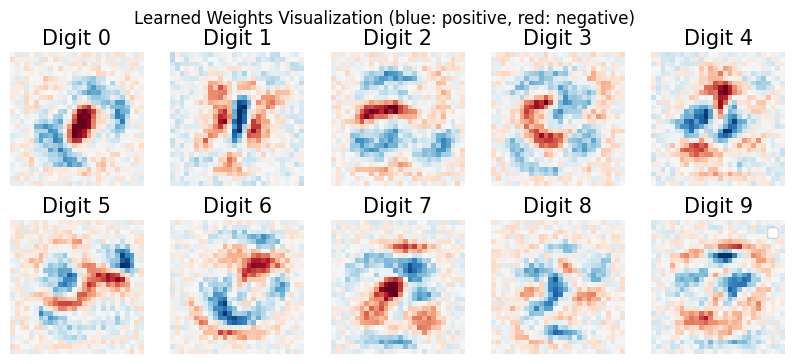

In [ ]:
visualize_weights2(model)

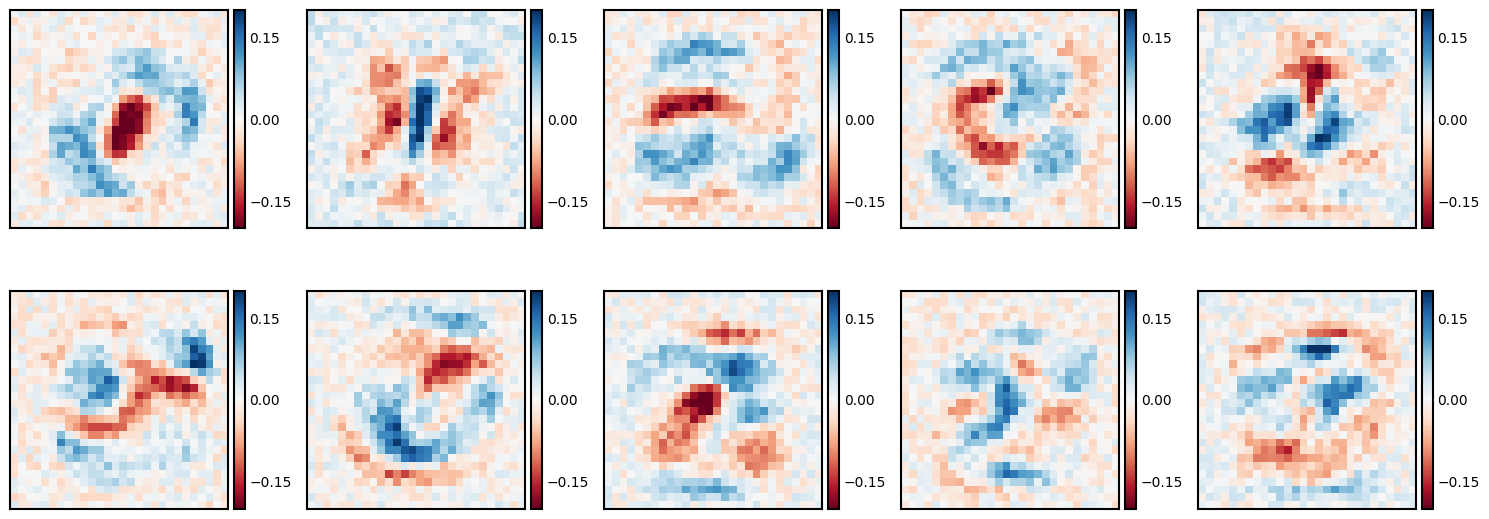

In [ ]:
isns.ImageGrid(model.neuron.weight.data.cpu().numpy().reshape(10,28,28), cmap='RdBu', col_wrap=5, axis=0, vmin=-0.2, vmax=0.2)